In [16]:
from vsrc.constants import DATA
from ultralytics import YOLO
from os import path, listdir, makedirs
from shutil import rmtree, copy
import random
import time
import cv2

### Load YOLOv8n Model

In [17]:
# Constants
IMAGE_SIZE = 128
PROJECT_NAME = "logs"
RECIPE_NAME = "resistor_values"
TRAIN_RUN = f"{RECIPE_NAME}_run-{time.strftime('%Y%m%d-%H%M%S')}"
DATA_PATH = "./../../datasets/partial/resistor"

# Model
MODEL_PATH = f"./models/pretrained/yolov8n-coco.pt"
TRAIN_PARAM = {
    # Model definition
    'data': f"./models/recipes/resistor_values.yaml",
    'resume': False,
    'device': '0',
    'pretrained': True,
    # Names
    'project' : PROJECT_NAME,
    'name': TRAIN_RUN,
    # Training Parameters
    'batch': 16,
    'imgsz': IMAGE_SIZE,
    'epochs': 100,
    'patience': 10,
    'cos_lr': True,
    # Augmentation
    'hsv_h': 0.05, # Higher than default for resistor
    'hsv_s': 0.3, # Colours should not change too much
    'hsv_v': 0.2, # Colours should not change too much
    'degrees': 5, # Rotation
    'translate': 0.0, # Translation
    'scale': 1.0, # Scaling - camera is always at the same distance
    'shear': 0.0, # Shearing
    'perspective': 0.0, # Perspective
    'flipud': 0.5, # Flip up-down
    'fliplr': 0.5, # Flip left-right
    'mosaic': 0.5, # Mosaic
    'mixup': 0.0, # Mixup
    'copy_paste': 0.0, # Copy-paste
    'crop_fraction': 1.0, # Crop fraction
    # Loss weights
    'cls' : 8.0, # Class 
    'box' : 2.0, # Box accuracy
    'dfl' : 1.5, # Help manage unbalanced classes
    # Post parameters
    'save': True,
    'save_period': 5,
    'plots': False,
    # Misc
    'verbose': False,
}

PATHS = {
    'train': f"{DATA_PATH}/training/images/train",
    'val': f"{DATA_PATH}/training/images/val",
    'test': f"{DATA_PATH}/training/images/test",
}

# Reorganise the data
PARAM = {
    'path' : DATA_PATH,
    'train' : 0.8,
    'val' : 0.2,
}

### Remove old dataset
DATASET_FOLDER = f"{DATA_PATH}/training"

In [67]:
if path.exists(DATASET_FOLDER):
    for folder in listdir(DATASET_FOLDER):
        rmtree(path.join(DATASET_FOLDER, folder), ignore_errors=True)
# Make label folder
makedirs(path.join(DATASET_FOLDER, 'labels'), exist_ok=False)
# Make train, val, test folders
for folder in ['train', 'val', 'test']:
    makedirs(path.join(DATASET_FOLDER, 'images', folder), exist_ok=False)
    makedirs(path.join(DATASET_FOLDER, 'labels', folder), exist_ok=False)


In [70]:
# Get all component images from all folders
basenames = []
# For component folder in dataset
imgfiles = listdir(path.join(PARAM['path'], 'imgs'))
labfiles = listdir(path.join(PARAM['path'], 'labels'))
bases = [path.splitext(f)[0] for f in imgfiles]
basenames.extend(bases)
print(f"Found {len(imgfiles)} images and {len(labfiles)} labels.")

# Split the data into train, val, test
random.shuffle(basenames)
train = int(len(basenames) * PARAM['train'])
val = int(len(basenames) * PARAM['val'])
test = int(len(basenames) * PARAM['test'])
print(f"Split into {train} train, {val} val, {test} test. Total: {train+val+test} images.")
train_set = basenames[:train]
val_set = basenames[train:train+val]
test_set = basenames[train+val:]

# Copy the images and labels to the new dataset folder
for folder, dataset in zip(['train', 'val', 'test'], [train_set, val_set, test_set]):
    for base in dataset:
        filename = path.split(base)[1]
        copy(path.join(PARAM['path'], "imgs", f"{base}.png"), path.join(DATASET_FOLDER, 'images', folder, f"{filename}.png"))
        base = base.replace('imgs', 'labels')
        copy(path.join(PARAM['path'], "labels", f"{base}.txt"), path.join(DATASET_FOLDER, 'labels', folder, f"{filename}.txt"))

Found 257 images and 257 labels.
Split into 179 train, 51 val, 25 test. Total: 255 images.


In [68]:
# Tensorboard logging
%load_ext tensorboard
%tensorboard --logdir "logs" --port=6005

Reusing TensorBoard on port 6005 (pid 25652), started 5 days, 0:10:17 ago. (Use '!kill 25652' to kill it.)

In [ ]:
! taskkill /PID 40156 /F

In [76]:
# Train
model = YOLO(MODEL_PATH).to('cuda')
model.train(**TRAIN_PARAM)

New https://pypi.org/project/ultralytics/8.2.22 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.20  Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 16384MiB)
engine\trainer: task=detect, mode=train, model=./models/pretrained/yolov8n-coco.pt, data=./models/recipes/resistor_values.yaml, epochs=20, time=None, patience=10, batch=16, imgsz=128, save=True, save_period=5, cache=False, device=0, workers=8, project=logs, name=resistor_values_run-20240526-001155, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False,

train: Scanning C:\Users\Shaheen\OneDrive - Imperial College London\Uni\CW Labs\Year 4\FYP\src\vision\datasets\partial\resistor\training\labels\train.cache... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<?, ?it/s]
val: Scanning C:\Users\Shaheen\OneDrive - Imperial College London\Uni\CW Labs\Year 4\FYP\src\vision\datasets\partial\resistor\training\labels\val.cache... 51 images, 0 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 128 train, 128 val
Using 8 dataloader workers
Logging results to logs\resistor_values_run-20240526-001155
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.797G     0.8302      76.81      2.136         37        128: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         51        323          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.755G     0.7288      74.72      1.773         17        128: 100%|██████████| 12/12 [00:01<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]

                   all         51        323          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.642G     0.6688      71.06      1.535         35        128: 100%|██████████| 12/12 [00:01<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         51        323          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.642G     0.6199      66.15      1.453          8        128: 100%|██████████| 12/12 [00:01<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         51        323     0.0141      0.102     0.0455     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.642G     0.6041      62.49      1.359         19        128: 100%|██████████| 12/12 [00:01<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         51        323      0.886     0.0746      0.113     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      0.64G     0.5687         60      1.265         27        128: 100%|██████████| 12/12 [00:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.10it/s]

                   all         51        323      0.908      0.104      0.178     0.0642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.642G     0.5627      56.28      1.278         47        128: 100%|██████████| 12/12 [00:01<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         51        323      0.907     0.0886      0.209     0.0764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      0.64G     0.5462      52.16      1.255         28        128: 100%|██████████| 12/12 [00:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         51        323      0.902      0.175      0.246     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.642G     0.5442      48.46      1.267         41        128: 100%|██████████| 12/12 [00:01<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         51        323      0.911      0.204      0.259     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      0.64G      0.532         47      1.261         16        128: 100%|██████████| 12/12 [00:01<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         51        323      0.926      0.227      0.281      0.118


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.638G     0.4982      40.98      1.266         18        128: 100%|██████████| 12/12 [00:01<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         51        323      0.857      0.254      0.299      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.638G     0.4857      39.57      1.264         14        128: 100%|██████████| 12/12 [00:01<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         51        323      0.865       0.26      0.318      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.638G      0.481      37.05       1.22         17        128: 100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         51        323      0.868      0.261      0.336      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.638G     0.4813      36.48      1.255         19        128: 100%|██████████| 12/12 [00:01<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         51        323       0.88      0.272      0.364      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.638G     0.4721      35.14      1.235         18        128: 100%|██████████| 12/12 [00:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         51        323      0.871      0.277      0.379      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.638G      0.455      35.42      1.214         17        128: 100%|██████████| 12/12 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

                   all         51        323      0.866       0.28      0.389      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.638G     0.4689      33.07      1.198         19        128: 100%|██████████| 12/12 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         51        323      0.857      0.292      0.395      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      0.64G     0.4537      33.17      1.212         17        128: 100%|██████████| 12/12 [00:01<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         51        323      0.831      0.328      0.398      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      0.64G     0.4544      32.91      1.224         12        128: 100%|██████████| 12/12 [00:01<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         51        323       0.83      0.328      0.403      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.638G     0.4619      32.86      1.182         19        128: 100%|██████████| 12/12 [00:01<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         51        323      0.828      0.327      0.409      0.197



20 epochs completed in 0.041 hours.
Optimizer stripped from logs\resistor_values_run-20240526-001155\weights\last.pt, 6.2MB
Optimizer stripped from logs\resistor_values_run-20240526-001155\weights\best.pt, 6.2MB

Validating logs\resistor_values_run-20240526-001155\weights\best.pt...
Ultralytics YOLOv8.2.20  Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 16384MiB)
Model summary (fused): 168 layers, 3008183 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         51        323      0.828      0.327      0.409      0.197
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.6ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000000A30446D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [77]:
# Test the model
metrics = model.val(data=TRAIN_PARAM['data'])

Ultralytics YOLOv8.2.20  Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 16384MiB)
Model summary (fused): 168 layers, 3008183 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\Shaheen\OneDrive - Imperial College London\Uni\CW Labs\Year 4\FYP\src\vision\datasets\partial\resistor\training\labels\val.cache... 51 images, 0 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

                   all         51        323      0.826      0.328      0.409      0.197
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.2ms postprocess per image


### Try Model

In [3]:
TEST_DATA = f"{DATA_PATH}/training/images/test"

def hex_to_bgr(hex):
    colour = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))
    return colour[::-1]

try:
    model
    print("Loaded trained model")
except:
    # Load the best model
    # List dir and find latest run
    runs = listdir(f"./logs")
    runs.sort()
    latest_run = runs[-1]
    modelPath = f"./logs/{latest_run}/weights/best.pt"
    print(f"Latest run: {latest_run}, loading model from {modelPath}")
    bestModel = YOLO(modelPath).to('cuda')
    model = bestModel
    print("Loaded best model")

classMap = {i: k for i, (k, v) in enumerate(DATA['resistors']['values'].items())} | {12 : "stem"}
colourMap = {i: hex_to_bgr(v[2][1::]) for i, (k, v) in enumerate(DATA['resistors']['values'].items())} | {12 : (179,179,0)}
print(colourMap)
print(classMap)
SCALE = 8
while cv2.waitKey(0) != ord('q'):
    cv2.destroyAllWindows()
    randomFile = random.choice(listdir(TEST_DATA))
    print(f"Random file: {randomFile}")
    results = model.predict(f"{TEST_DATA}/{randomFile}")
    # Need to upscale the image to show boxes
    img = cv2.imread(f"{TEST_DATA}/{randomFile}")
    img = cv2.resize(img, (img.shape[1]*SCALE, img.shape[0]*SCALE))
    for result in results:
        for i, _ in enumerate(result.boxes.cls):
            print(result)
            conf = result.boxes.conf[i]
            cls = result.boxes.cls[i].item()
            x1, y1, x2, y2 = result.boxes.xyxy[i]
            print(f"Conf: {conf}, Class: {cls}, Box: {x1, y1, x2, y2}")
            cv2.rectangle(img, (int(x1*SCALE), int(y1*SCALE)), (int(x2*SCALE), int(y2*SCALE)), colourMap[cls], 2)
            cv2.putText(img, f"{classMap[cls]}: {conf:.2f}", (int(x1*SCALE), int(y1*SCALE)), cv2.FONT_HERSHEY_SIMPLEX, 1, colourMap[cls], 2)
    cv2.imshow("Image", img)
cv2.destroyAllWindows()

Latest run: resistor_values_run-20240526-001155, loading model from ./logs/resistor_values_run-20240526-001155/weights/best.pt
Loaded best model
{0: (0, 0, 0), 1: (19, 69, 139), 2: (0, 0, 255), 3: (0, 165, 255), 4: (0, 255, 255), 5: (0, 255, 0), 6: (255, 0, 0), 7: (238, 130, 238), 8: (128, 128, 128), 9: (255, 255, 255), 10: (0, 215, 255), 11: (192, 192, 192), 12: (179, 179, 0)}
{0: 'black', 1: 'brown', 2: 'red', 3: 'orange', 4: 'yellow', 5: 'green', 6: 'blue', 7: 'violet', 8: 'grey', 9: 'white', 10: 'gold', 11: 'silver', 12: 'stem'}
Random file: obb_resistor_grey_orange_black_silver_brown_red_830E-2-1_9.png

image 1/1 c:\Users\Shaheen\OneDrive - Imperial College London\Uni\CW Labs\Year 4\FYP\src\vision\datasets\partial\resistor\training\images\test\obb_resistor_grey_orange_black_silver_brown_red_830E-2-1_9.png: 128x64 1 {0: 'black'}, 1 {1: 'brown'}, 2 {2: 'red'}s, 1 {12: 'stem'}, 191.0ms
Speed: 4.5ms preprocess, 191.0ms inference, 1096.0ms postprocess per image at shape (1, 3, 128, 64)

In [42]:
# need to rename class from 42 to 12
import re
for file in listdir("./datasets/partial/resistor/labels"):
    with open(f"./datasets/partial/resistor/labels/{file}", 'r') as f:
        lines = f.readlines()
    with open(f"./datasets/partial/resistor/labels/{file}", 'w') as f:
        for line in lines:
            f.write(re.sub(r"^42 ", "12 ", line))

### Calculate distribution of images sizes

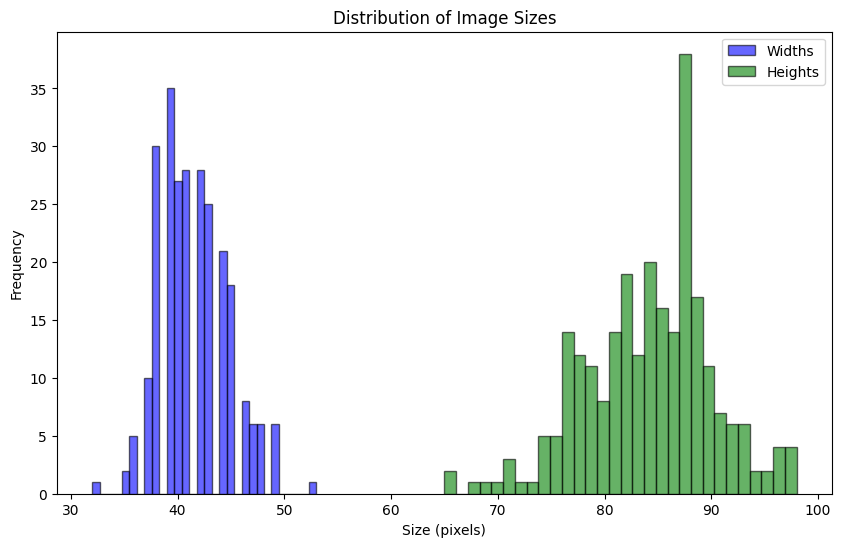

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def get_image_sizes(folder_path):
    image_sizes = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            with Image.open(image_path) as img:
                image_sizes.append(img.size)  # img.size returns (width, height)
    return image_sizes

def plot_image_size_distribution(image_sizes):
    widths = [size[0] for size in image_sizes]
    heights = [size[1] for size in image_sizes]

    plt.figure(figsize=(10, 6))

    plt.hist(widths, bins=30, color='blue', alpha=0.6, edgecolor='black', label='Widths')
    plt.hist(heights, bins=30, color='green', alpha=0.6, edgecolor='black', label='Heights')

    plt.title('Distribution of Image Sizes')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    folder_path = "./../../datasets/partial/resistor/imgs"
    image_sizes = get_image_sizes(folder_path)
    if image_sizes:
        plot_image_size_distribution(image_sizes)
    else:
        print("No images found in the specified folder.")


In [15]:
# sort images by width
print(sorted(image_sizes, key=lambda x: x[0]))

[(32, 71), (35, 69), (35, 68), (36, 75), (36, 65), (36, 66), (36, 72), (36, 75), (37, 76), (37, 78), (37, 78), (37, 77), (37, 75), (37, 82), (37, 74), (37, 82), (37, 81), (37, 78), (38, 81), (38, 81), (38, 79), (38, 77), (38, 82), (38, 77), (38, 79), (38, 89), (38, 88), (38, 80), (38, 81), (38, 83), (38, 77), (38, 81), (38, 83), (38, 87), (38, 78), (38, 79), (38, 74), (38, 77), (38, 85), (38, 74), (38, 78), (38, 73), (38, 81), (38, 79), (38, 71), (38, 76), (38, 78), (38, 82), (39, 77), (39, 79), (39, 83), (39, 81), (39, 70), (39, 82), (39, 84), (39, 84), (39, 85), (39, 87), (39, 86), (39, 85), (39, 82), (39, 80), (39, 82), (39, 83), (39, 79), (39, 81), (39, 82), (39, 82), (39, 85), (39, 83), (39, 88), (39, 82), (39, 87), (39, 86), (39, 78), (39, 84), (39, 76), (39, 76), (39, 82), (39, 81), (39, 83), (39, 79), (39, 84), (40, 80), (40, 87), (40, 85), (40, 79), (40, 89), (40, 84), (40, 88), (40, 87), (40, 87), (40, 83), (40, 86), (40, 90), (40, 87), (40, 84), (40, 84), (40, 85), (40, 88),